# Exploring Ensemble Methods

In [1]:
#Libraries Import
import json
import string
import numpy as np
import pandas as pd
from math import exp
from math import sqrt
import matplotlib.pyplot as plt
pd.set_option("Chained_Assignment",None)
from sklearn.ensemble import GradientBoostingClassifier


In [2]:
#read dataframe
loans=pd.read_csv("lending-club-data.csv",low_memory=False)

In [3]:
#we reassign the labels to have +1 for a safe loan, and -1 for a risky (bad) loan.
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.drop('bad_loans',axis=1)

In [4]:
#Selecting features
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]
loans= loans[[target] + features]

In [5]:
# Skipping observations with missing values

print (loans.shape)
loans=loans.dropna()
print("Dropping missing values: ")
print (loans.shape)


(122607, 25)
Dropping missing values: 
(122578, 25)


In [6]:
#creating dummy variables
col_cat_names=[]
[col_cat_names.append(x) for x,y in zip(loans.columns,loans.dtypes) if y==object]

for attr in col_cat_names:
    loans = loans.merge(pd.get_dummies(loans[attr], prefix=attr), left_index=True, right_index=True)
    loans.drop(attr,axis=1,inplace=True)

In [7]:
with open('module-8-assignment-1-train-idx.json') as train_data_file:    
    train_idx  = json.load(train_data_file)
with open('module-8-assignment-1-validation-idx.json') as validation_data_file:    
    validation_idx = json.load(validation_data_file)

train_data = loans.iloc[train_idx]
validation_data = loans.iloc[validation_idx]

In [8]:
#Gradient Boosting Classifier modeling
train_Y = train_data['safe_loans'].values
train_X = train_data.drop('safe_loans', axis=1).values
model = GradientBoostingClassifier(n_estimators=5, max_depth=6)
model_5=model.fit(train_X, train_Y)

In [9]:
# Select all positive and negative examples.
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

# Select 2 examples from the validation set for positive & negative loans
sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

# Append the 4 examples into a single dataset
sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
22,1,0.2,0,3,29.44,6.30496,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
26,1,0.6,1,1,12.19,13.49520,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
24,-1,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
41,-1,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0


In [10]:
#Making predictions
sample_validation_data_predictions=model_5.predict(sample_validation_data.drop('safe_loans', axis=1).values)

# QUIZ Exploring Ensemble Methods

#### Question 1
What percentage of the predictions on sample_validation_data did model_5 get correct?

__Ans__:

In [11]:
print("Accuracy:",round((np.asarray(sample_validation_data_predictions==sample_validation_data["safe_loans"],dtype=int).sum()/len(sample_validation_data)),2)*100)

Accuracy: 75.0


#### Question 2
According to model_5, which loan is the least likely to be a safe loan?

__Ans__: Third

In [12]:
[x[0] for x in model_5.predict_proba(sample_validation_data.drop('safe_loans', axis=1).values)]

[0.41642330873786404,
 0.46949689160229346,
 0.5380779230307647,
 0.39591638655587735]

#### Question 3
What is the number of false positives on the validation data?

__Ans__: 1653

In [13]:
#Evaluating the model on the validation data
validation_Y = validation_data['safe_loans'].values
validation_X = validation_data.drop('safe_loans', axis=1).values

print("Accuracy: ",round(model_5.score(validation_X,validation_Y)*100,2))

Accuracy:  66.14


In [14]:
# Calculate the number of false positives made by the model.
predictions = model_5.predict(train_X)
false_positive = np.asarray(((predictions==1) * (train_Y==-1)),dtype=int).sum()
print (false_positive)

6423


In [15]:
# Calculate the number of negatives made by the model.
predictions = model_5.predict(train_X)
false_negative = np.asarray(((predictions==-1) * (train_Y==1)),dtype=int).sum()
print (false_negative)

6027


In [16]:
#What is the number of false positives on the validation_data?
predictions = model_5.predict(validation_X)
false_positive = np.asarray(((predictions==1) * (validation_Y==-1)),dtype=int).sum()
print (false_positive)

1653


In [17]:
# Calculate the number of false negatives on the validation_data
predictions = model_5.predict(validation_X)
false_negative = np.asarray(((predictions==-1) * (validation_Y==1)),dtype=int).sum()
print (false_negative)

1491


#### Question 4
Using the same costs of the false positives and false negatives, what is the cost of the mistakes made by the boosted tree model (model_5) as evaluated on the validation_set?m

__Ans__: 47970000

In [18]:
print ("Cost: ",(10000 * false_negative) + (20000 * false_positive))

Cost:  47970000


#### Question 5
What grades are the top 5 loans?

__Ans__: A

In [19]:
validation_data["predictions"]=[x[1] for x in model_5.predict_proba(validation_X)]
top_5=validation_data.sort_values("predictions",ascending=False)[:5]
top_5[['grade_A','grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G']]

,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
8021,1,0,0,0,0,0,0
7271,1,0,0,0,0,0,0
71667,1,0,0,0,0,0,0
72452,1,0,0,0,0,0,0
109114,1,0,0,0,0,0,0


#### Question 6
Which model has the best accuracy on the validation_data?

__Ans__: model_200

In [20]:
model_10 = GradientBoostingClassifier(n_estimators=10, max_depth=6).fit(train_X, train_Y)
model_50 = GradientBoostingClassifier(n_estimators=50, max_depth=6).fit(train_X, train_Y)
model_100 = GradientBoostingClassifier(n_estimators=100, max_depth=6).fit(train_X, train_Y)
model_200 = GradientBoostingClassifier(n_estimators=200, max_depth=6).fit(train_X, train_Y)
model_500 = GradientBoostingClassifier(n_estimators=500, max_depth=6).fit(train_X, train_Y)


In [21]:
print ("Model-10 Accuracy: ",model_10.score(validation_X,validation_Y))
print ("Model-50 Accuracy: ",model_50.score(validation_X,validation_Y))
print ("Model-100 Accuracy: ",model_100.score(validation_X,validation_Y))
print ("Model-200 Accuracy: ",model_200.score(validation_X,validation_Y))
print ("Model-500 Accuracy: ",model_500.score(validation_X,validation_Y))

Model-10 Accuracy:  0.6663076260232659
Model-50 Accuracy:  0.6846186988367083
Model-100 Accuracy:  0.6898965962947006
Model-200 Accuracy:  0.6866652305040931
Model-500 Accuracy:  0.6893580353295993


#### Question 7
Is it always true that the model with the most trees will perform best on the test/validation set?

__Ans__: No, a model with more trees does not always perform better on the test/validation set.

#### Question 8
Does the training error reduce as the number of trees increases?

__Ans__: Yes

In [22]:
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In [23]:
#error= 1-accuracy
train_err_10 = 1-model_10.score(train_X,train_Y)
train_err_50 = 1-model_50.score(train_X,train_Y)
train_err_100 = 1-model_100.score(train_X,train_Y)
train_err_200 = 1-model_200.score(train_X,train_Y)
train_err_500 = 1-model_500.score(train_X,train_Y)

training_errors = [train_err_10, train_err_50, train_err_100, 
                   train_err_200, train_err_500]

validation_err_10 = 1-model_10.score(validation_X,validation_Y)
validation_err_50 = 1-model_50.score(validation_X,validation_Y)
validation_err_100 = 1-model_100.score(validation_X,validation_Y)
validation_err_200 = 1-model_200.score(validation_X,validation_Y)
validation_err_500 = 1-model_500.score(validation_X,validation_Y)

validation_errors = [validation_err_10, validation_err_50, validation_err_100, 
                     validation_err_200, validation_err_500]

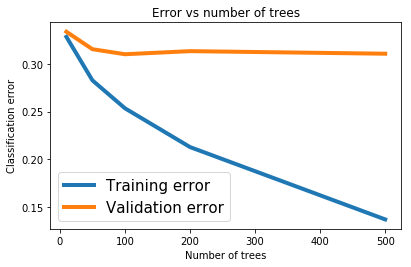

In [24]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')



#### Question 9
Is it always true that the test/validation error will reduce as the number of trees increases?

__Ans__: No, the test/validation error will not necessarily always reduce as the number of trees increases.